## Introduction

We have a small dataset and a very simple two-class classification tasks. There are 5000 examples and two real-valued features. Half of the examples are labeled 1 the other half labeled 0. We will split the dataset into training and test sets, and throw a few well-known ML models at it. We do not know the domain of the data, nor the interpretation of features and labels. This is a toy dataset, and analysis done on it will be non-rigorous. However, trivial datasets can sometimes yield surprising insights, for example, [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet). 

We shall use python in this article for the analysis, so first let's the nesseary packages import out of the way.

In [1]:
%matplotlib inline

from itertools import cycle

import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import normalize

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


import os
import sys
import timeit

import theano
import theano.tensor as T

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days


## Data Generation

Here's the big reveal. This simple dataset is in fact artifitial. The two classes (Label = 0 / 1) are merely two rings of radius 1 and 2, with a little bit randomness spiced in. To be more specific, we sampled from two independent random variables:

$$\mathbf{R} \sim \text{Gaussian}$$

$$\mathbf{\theta} \sim \text{Uniform}$$

With respect to different labels, the parameters of distributions are:

$$\mathbf{R|Y=0} \sim N(1, 0.1)$$

$$\mathbf{R|Y=1} \sim N(2, 0.1)$$

$$\mathbf{\theta} \sim U(0, 2\pi)$$

Each sample is just a pair of $r_i$ and $\theta_i$ values: $(r_i, \theta_i)$ given $y_i$. However, the final dataset exposed to classifiers has undergone an additional step of transformation, we present the Cartesian coordinations $(x,y)$ to ML models, rather than raw $(r, \theta)$ pairs. That is:

$$\mathbf{X} = \mathbf{R} \cos(\theta)$$

$$\mathbf{Y} = \mathbf{R} \sin(\theta)$$

The dataset features (variable `X`) are a 2d numpy array, each row being $(x_i, y_i)$ generated this way. 

In [2]:
def ring_data(r, sigma=0.1, size=2500):
    '''
    Create (r, theta) pairs where 
      r ~ Normal
      theta ~ Uniform(0, 2 * PI)
    '''
    rs, thetas = np.random.normal(r, sigma, size), \
                 np.random.uniform(0, np.pi * 2, size)
    return np.column_stack((rs, thetas))

def gen_dataset_polar(size=2500):
    '''
    Generate random dataset with labels 0/1
    features are polar coordinates
    For Y=0:  r ~= 1
    For Y=1:  r ~= 2
    theta values are uniformly distributed in [0, 2 * PI]
    '''
    X = np.row_stack((ring_data(1, size=size), 
                      ring_data(2, size=size)) )
    Y = np.array((np.zeros(size), np.ones(size))).reshape((size*2,))
    return X,Y

def pol2cart(X):
    '''
    Polar to Cartesian 
    2d array -> 2d array
    '''
    r = X[:,0]
    theta = X[:,1]
    return np.column_stack((np.cos(theta) * r, 
                            np.sin(theta) *r))
np.random.seed(0)
X0, Y = gen_dataset_polar()

shuffle = np.random.permutation(np.arange(X0.shape[0]))
X0, Y = X0[shuffle], Y[shuffle]

X = pol2cart(X0) 

for _ in range(4):
    X = pol2cart(X)

train_data, train_labels = X[1500:], Y[1500:]
test_data, test_labels = X[:1500], Y[:1500]

A basic scatteplot of the dataset captures pretty much the whole story about how this dataset is constructed.

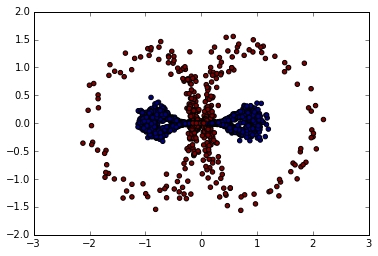

In [3]:
def vis(X, Y):
    plt.scatter(X[:,0], X[:,1],c=Y)
    
vis(train_data, train_labels)

To establish some context, let's plot the histograms of feature 1 and 2 - for both classes. It seems both features are bounded ($[-2, 2]$), and there doesn't seem to be any noticable difference in distribution for both features between classes. 

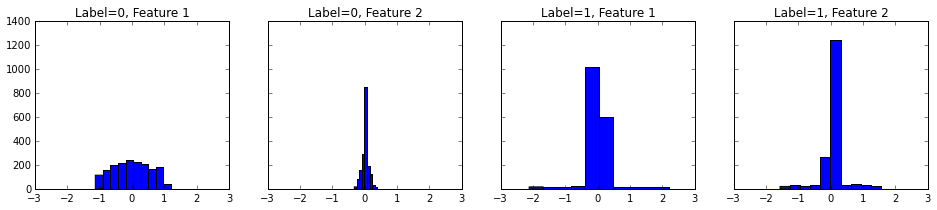

In [4]:
idx_0 = np.argwhere(train_labels!=1.0).ravel()
idx_1 = np.argwhere(train_labels==1.0).ravel()

fig, axarr = plt.subplots(1, 4, sharex=True, sharey=True)
axarr[0].hist(train_data[idx_0][:,0])
axarr[0].set_title('Label=0, Feature 1')
axarr[1].hist(train_data[idx_0,1])
axarr[1].set_title('Label=0, Feature 2')
axarr[2].hist(train_data[idx_1][:,0])
axarr[2].set_title('Label=1, Feature 1')
axarr[3].hist(train_data[idx_1,1])
axarr[3].set_title('Label=1, Feature 2')
# fig.suptitle('Histogram of two features for subsets of training data')
fig.set_figheight(3)
fig.set_figwidth(16)




The first classifier we'd like to try on the training set is the most trivial one. You might be thinking K Nearest Neighbor? No, it's dumber than that. It's a classifer that always predict the most frequent label encountered in training data, let's just call it `BaselineClassifier`.

The next trival classifier will be termed _dice roll classifier_ (in case of a two-class problem like we have here, it degenerates to _coin flip classifier_). The basic idea is count the frequency of training labels, and roll a dice based on these frequencies at prediction time. In this case, it's pretty much predict based on coin tosses: heads label=1 tail label=0. Both of these trival classifiers completely ignore any features.

DicerollClassifier is strictly inferior compared to BaselineClassifier if measured by _expected_ prediction error rate (however, BaselineClassifier is more volatile). To prove this, for two-class classification problems, denote the population label distribution as $Y \sim \text{Bernoulli}(p)$. Both classifier will estimate the same $\hat{p}$ as proportion of examples with label 1 in the training set. 

For BaselineClassifier, the probability of a correct classification is ($n$ is training sample size, using CLT):

$$ 
\begin{split}
\Pr[\mathbf{1}_{\hat{p}>0.5} = Y] &= \Pr[\hat{p} \leq 0.5 \text{ and } Y=0] + \Pr[\hat{p}>0.5 \text{ and } Y=1] \\
                                 &= \Pr[\hat{p} \leq 0.5]\Pr[Y=0] + \Pr[\hat{p} > 0.5]\Pr[Y=1] \\
                                 &\approx \Phi(\frac{0.5-p}{\sqrt{np(1-p)}}) * (1-p) + (1-\Phi(\frac{0.5-p}{\sqrt{np(1-p)}})) * p 
\end{split}
$$


For DicerollClassifier, the probability of a correct classification is:
$$
\begin{split}
E[\hat{p}p + (1-\hat{p})p] &= p^2 + (1-p^2) \\
                           &= 2p^2 - 2p + 1
\end{split}
$$

And graph the two probabilitys for different $p$'s:

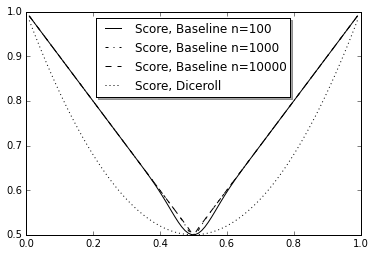

In [5]:
def graph_score_p():
    ps = np.linspace(0.01, 1.0, num=100, endpoint=False)

    score_dr = 2 * ps * ps - 2 * ps + 1.0
    
    fig, ax = plt.subplots()
    
    
    for n,k in zip([100, 1000, 10000], ['k','k-.','k--']):
        sds = np.sqrt(ps * (1.0-ps)/n)
        xs = (0.5-ps) / sds
        phis = norm.cdf(xs)

        score_bl = phis * (1.0-ps) + (1.0-phis) * ps
        ax.plot(ps, score_bl, k, label='Score, Baseline n=%d' % n)
    
    ax.plot(ps, score_dr, 'k:', label='Score, Diceroll')
    
    # Now add the legend with some customizations.
    legend = ax.legend(loc='upper center', shadow=True)

    plt.show()
    
graph_score_p()

One thing to keep notice, score or error rate of a classifier is a random variable, meaning different training data will produce different error rates, the graph above merely plots the expected error rate with respect to true $p$ of the population, which is unknownable. The above reasoning follows a frequentist approach, however, in a Bayesian setup the conclusion remain the same (roughly) if we assumes an uninformative prior ($p \sim \text{Uniform(0,1)})$.

Looking at the graph above, one might be tempted to conclude these trival classifiers perform well for very large or small $p$ (imbalanced samples); however, it's important to realize in this senario, the usefulness of error rate as a classifier performance measure is greatly reduced. One should consult measures summarized in sklearn [classification report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) and others such as ROC curve for probablistic classifiers. 

Nonetheless, this pair of trival classifiers produce a good starting point in a sense if one actual classifier performs significantly worse than them in terms of error rate, it means some fundamental assumptions/conditions of said classifier have been violated by the data -  a good hint to invetigate further and will almost for sure lead to the knowledge of some important and/or hidden properties of the dataset.  

Now to try them on our dataset:

In [6]:
class BaselineClassifier(ClassifierMixin):
    def __init__(self):
        self.classes = None
        self._prediction = None
        self._predict_prob = None
    
    def fit(self, train_data, train_labels):
        classes, counts = np.unique(train_labels, return_counts=True)
        self.classes = classes
        label_probs = counts.astype('float64') / train_labels.shape[0]
        self._predict_prob = np.max(label_probs)
        self._prediction = classes[np.argmax(counts)]
    
    # Make predictions for each test example and return results.
    def predict(self, test_data):
        preds = np.empty(test_data.shape[0])
        preds.fill(self._prediction)
        return preds
    def predict_proba(self, test_data):
        preds = np.empty(test_data.shape[0])
        preds.fill(self._predict_prob)
        return preds

In [7]:
base = BaselineClassifier()

base.fit(train_data, train_labels)

base.score(test_data, test_labels)


0.49533333333333335

In [8]:
class DicerollClassifier(ClassifierMixin):
    def __init__(self):
        self.classes = None
        self.label_probs = None
    
    def fit(self, train_data, train_labels):
        classes, counts = np.unique(train_labels, return_counts=True)
        self.classes = classes
        self.label_probs = counts.astype('float64') / train_labels.shape[0]
    
    # Make predictions for each test example and return results.
    def predict(self, test_data):
        n = test_data.shape[0]
        return np.random.choice(self.classes, size=n, 
                                replace=True,
                                p=self.label_probs)

In [9]:
diceroll = DicerollClassifier()

diceroll.fit(train_data, train_labels)

diceroll.score(test_data, test_labels)


0.49933333333333335

The next classifier in line in terms of simplicity is KNeighborsClassifier. Base on the histogram we saw earlier, both features have large variations for class 1, therefore it might be a good idea to normalize the data before feeding it to a classifier:

In [10]:
train_data_norm = normalize(train_data, axis=1)
test_data_norm = normalize(test_data, axis=1)

In [12]:
knn = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree')

knn.fit(train_data_norm, train_labels)

knn.score(test_data_norm, test_labels)

0.64933333333333332

Not looking good, just barely above a coin flip. Let's try LogisticRegression instead?

In [13]:
logit = LogisticRegression(penalty='l2')

logit.fit(train_data_norm, train_labels)

logit.score(test_data_norm, test_labels)

0.54933333333333334

In [14]:
def imbalance(p, X, Y):
    '''
    Function to create imbalanced subset of data with given ratio of Label=1 examples,
    assumes input dataset are balanced in the first place
    
    :type p: float
    :param p: proportion of subset has label=1

    :type X: 2d array
    :param X: features

    :type Y: 1d array
    :param Y: labels
    '''
    zero_indices = np.argwhere(Y==0.0).ravel()
    one_indices = np.argwhere(Y!=0.0).ravel()
    
    n0, = zero_indices.shape
    n1, = one_indices.shape
    # assume n0 ~= n1
    n0prime = int(n0 * (1-p))
    n1prime = int(n1 * p)
    
    zero_indices = np.random.choice(zero_indices, n0prime,
                                    replace=False)
    one_indices = np.random.choice(one_indices, n1prime,
                                    replace=False)
    indices = np.concatenate((zero_indices, one_indices))
    indices = np.random.permutation(indices)
    
    return X[indices], Y[indices]



In [15]:
def score_by_p(p, Clf, train_data=train_data_norm, 
                       train_labels=train_labels, 
                       test_data=test_data_norm,
                       test_labels=test_labels, params={}):
    _train_data, _train_labels = imbalance(p, train_data, train_labels)
    _test_data, _test_labels = imbalance(p, test_data, test_labels)
    clf = Clf(**params)
    clf.fit(_train_data, _train_labels)
    return clf.score(_test_data, _test_labels)

In [16]:
class ScoreGraph(object):
    def __init__(self, name, pfrom=0.01, pto=1.0):
        self.name = name
        self.n_train = 1
        self.ps = np.linspace(pfrom, pto, num=100, endpoint=False)
        self.scores = {
          "baseline" : None,
          "diceroll" : None
        }
        self.scores[name] = None        
        
    def compute_bench_scores(self, train_data, 
                                   train_labels,
                                   test_data, 
                                   test_labels, empirical=False):
        self.n_train = train_data.shape[0]
        if empirical:
            score_ps_bl = \
              np.vectorize(lambda p: score_by_p(p,
                                                train_data=train_data,
                                                train_labels=train_labels,
                                                test_data=test_data,
                                                test_labels=test_labels,
                                                Clf=BaselineClassifier))
    
            score_ps_dr = \
              np.vectorize(lambda p: score_by_p(p,
                                                train_data=train_data,
                                                train_labels=train_labels,
                                                test_data=test_data,
                                                test_labels=test_labels,
                                                Clf=DicerollClassifier))
        else:
            score_ps_dr = ScoreGraph.score_ps_dr
            score_ps_bl = lambda ps: ScoreGraph.score_ps_bl(self.n_train, ps)
            
        self.scores["baseline"] = score_ps_bl(self.ps)
        self.scores["diceroll"] = score_ps_dr(self.ps)
        
    def compute_clf_scores(self, Clf, train_data, 
                                 train_labels, 
                                 test_data, 
                                 test_labels, params={}):
        scorer = \
          np.vectorize(lambda p: score_by_p(p,
                                            train_data=train_data,
                                            train_labels=train_labels,
                                            test_data=test_data,
                                            test_labels=test_labels,
                                            Clf=Clf, params=params))
        self.scores[self.name] = scorer(self.ps)
        
    def graph_all(self):
        fig, ax = plt.subplots()
        color = cycle(['c', 'm', 'y', 'k'])
        ls = cycle(['k:', 'k-', 'k', 'k--'])
        for name,scores in self.scores.iteritems():
            if scores is not None:
                ax.plot(self.ps, scores, ls.next(), 
                        label='Score, %s' % name, color=color.next())
        
        # Now add the legend with some customizations.
        legend = ax.legend(loc='lower left', bbox_to_anchor=(1.1, .05), shadow=True)
        plt.xlabel('p: proportion of examples that are labeled 1')
        plt.show()

    
    @staticmethod
    def score_ps_dr(ps):
        return 2 * ps * ps - 2 * ps + 1.0
        
    @staticmethod
    def score_ps_bl(n, ps):
        sds = np.sqrt(ps * (1.0-ps)/n)
        xs = (0.5-ps) / sds
        phis = norm.cdf(xs)

        return phis * (1.0-ps) + (1.0-phis) * ps

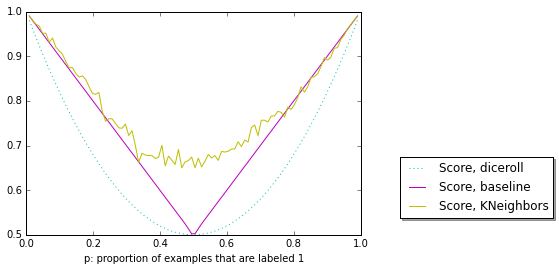

In [17]:
graph = ScoreGraph('KNeighbors')

graph.compute_bench_scores(train_data_norm, train_labels, 
                           test_data_norm, test_labels)

graph.compute_clf_scores(KNeighborsClassifier, 
                         train_data_norm, train_labels, 
                         test_data_norm, test_labels)

graph.graph_all()

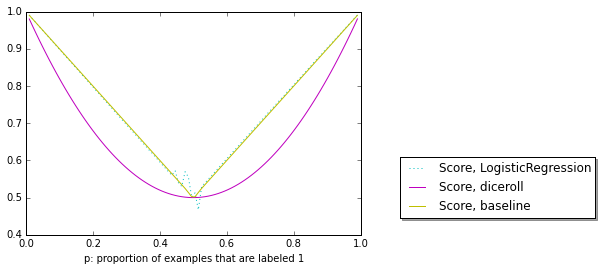

In [18]:
graph = ScoreGraph('LogisticRegression')

graph.compute_bench_scores(train_data_norm, train_labels, 
                           test_data_norm, test_labels)

graph.compute_clf_scores(LogisticRegression, 
                         train_data_norm, train_labels, 
                         test_data_norm, test_labels)

graph.graph_all()

In [19]:
knn = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree')

knn.fit(train_data, train_labels)

knn.score(test_data, test_labels)



0.83733333333333337

Normalization is a common processing step, let's try it on our dataset with knn. It's good to know using normalization on input features is equivlant to using Cosine similarity, see this [stackoverflow answer](http://stackoverflow.com/questions/34144632/using-cosine-distance-with-scikit-learn-kneighborsclassifier). Let's see...

In [20]:
knn2 = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree')

knn2.fit(normalize(train_data), train_labels)

knn2.score(normalize(test_data), test_labels)

0.64933333333333332

Ouch, the score drops to the level of baseline classifiers. What does this tell us? Without additional information, it seems euclidean similarity is meaningful in terms of distinguish the two classes, but not cosine similarity. In other words, euclidean distances to origin (0,0) of each example is a useful measure in seperating the two classes, and normalization removes this information.  

Ok, let's plot the histograms of feature norms for the two classes to see if this is true.

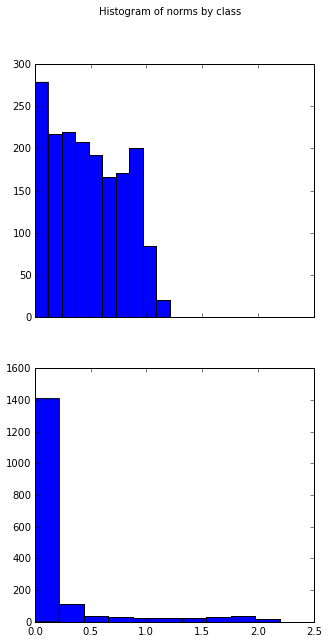

In [21]:
fig, axarr = plt.subplots(2, 1, sharex=True)
axarr[0].hist(np.apply_along_axis(np.linalg.norm, 1, train_data[idx_0]))
axarr[1].hist(np.apply_along_axis(np.linalg.norm, 1, train_data[idx_1]))
fig.suptitle('Histogram of norms by class')
fig.set_figheight(10)
fig.set_figwidth(5)



Aha, our suspition has been confirmed. By the looks of it, the norm of features look normal and class 1 and 0 have similar variance but different means. Our knn models results natrually suggests an alternative classifier: logistic regression on transformed feature, transformation being normalization. Let's try it out.

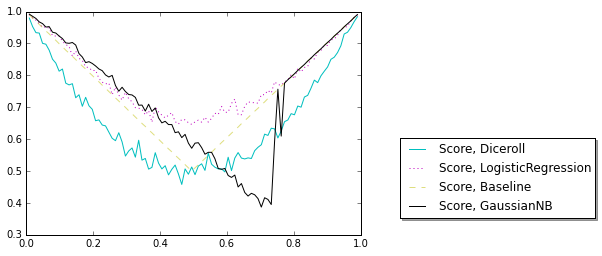

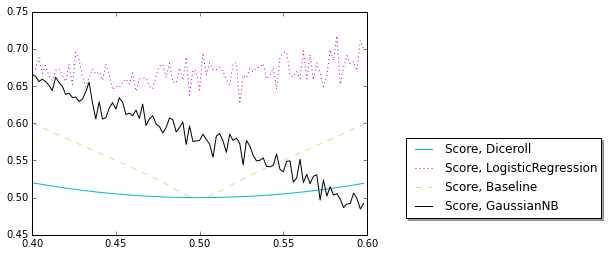

In [22]:
def imbalance(p, X, Y):
    '''
    function to create imbalanced samples 
    '''
    zero_indices = np.argwhere(Y==0.0).ravel()
    one_indices = np.argwhere(Y!=0.0).ravel()
    
    n0, = zero_indices.shape
    n1, = one_indices.shape
    # assume n0 ~= n1
    n0prime = int(n0 * (1-p))
    n1prime = int(n1 * p)
    
    zero_indices = np.random.choice(zero_indices, n0prime,
                                    replace=False)
    one_indices = np.random.choice(one_indices, n1prime,
                                    replace=False)
    indices = np.concatenate((zero_indices, one_indices))
    indices = np.random.permutation(indices)
    
    return X[indices], Y[indices]

def score_by_p(p, Clf, params={}):
    _train_data, _train_labels = imbalance(p, train_data, train_labels)
    _test_data, _test_labels = imbalance(p, test_data, test_labels)
    clf = Clf(**params)
    clf.fit(normalize(_train_data), _train_labels)
    return clf.score(normalize(_test_data), _test_labels)

score_ps_logit = \
    np.vectorize(lambda p: score_by_p(p, KNeighborsClassifier))

score_ps_gnb = \
    np.vectorize(lambda p: score_by_p(p, GaussianNB))
    
score_ps_bl = \
    np.vectorize(lambda p: score_by_p(p, BaselineClassifier))
    
score_ps_dr = \
    np.vectorize(lambda p: score_by_p(p, DicerollClassifier))

def graph_score_p_empirical(pfrom=0.01, pto=1.0, empirical=True):
    ps = np.linspace(pfrom, pto, num=100, endpoint=False)
    n = int(train_labels.shape[0] / 2)
    
    if empirical:
        score_bl = score_ps_bl(ps)
        score_dr = score_ps_dr(ps)
    else:
        sds = np.sqrt(ps * (1.0-ps)/n)
        xs = (0.5-ps) / sds
        phis = norm.cdf(xs)
        score_bl = phis * (1.0-ps) + (1.0-phis) * ps
        score_dr = 2 * ps * ps - 2 * ps + 1.0
        
    
    score_logit = score_ps_logit(ps)
    score_gnb = score_ps_gnb(ps)
    
    fig, ax = plt.subplots()
    
    ax.plot(ps, score_dr, 'k', label='Score, Diceroll', color='c')
    ax.plot(ps, score_logit, 'k:', label="Score, LogisticRegression", color='m')
    ax.plot(ps, score_bl, 'k--', label='Score, Baseline', color='y', alpha=0.5)
    ax.plot(ps, score_gnb, 'k-', label="Score, GaussianNB", color='k')
    
    # Now add the legend with some customizations.
    legend = ax.legend(loc='lower left', bbox_to_anchor=(1.1, .05), shadow=True)

    plt.show()
    
graph_score_p_empirical()
graph_score_p_empirical(0.4, 0.6, empirical=False)

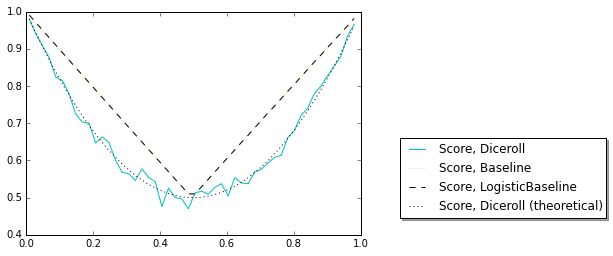

In [23]:
class LogisticBaseline(LogisticRegression):
    def __init__(self, **kwargs):
        kwargs["fit_intercept"] = False
        LogisticRegression.__init__(self, **kwargs)
    
    def fit(self, train_data, train_labels):
        n, = train_labels.shape
        _train_data = np.ones(dtype='float64', shape=(n,1))
        LogisticRegression.fit(self, _train_data, train_labels)
    
    # Make predictions for each test example and return results.
    def predict(self, test_data):
        n,_ = test_data.shape
        _test_data =np.ones(dtype='float64', shape=(n,1))
        return super(LogisticBaseline, self).predict(_test_data)
    
score_ps_lb = \
    np.vectorize(lambda p: score_by_p(p, LogisticBaseline, {"penalty": "l2"}))

def graph_score_p_empirical():
    ps = np.linspace(0.01, 1.0, num=50, endpoint=False)
    n = int(train_labels.shape[0] / 2)
    
    score_bl = score_ps_bl(ps)
    score_dr = score_ps_dr(ps)
    
    score_lb = score_ps_lb(ps)
    
    score_dr_t = 2 * ps * ps - 2 * ps + 1.0
    
    fig, ax = plt.subplots()
    
    ax.plot(ps, score_dr, 'k', label='Score, Diceroll', color='c')
    ax.plot(ps, score_bl, 'k-', label='Score, Baseline', color='y',alpha=0.2)
    ax.plot(ps, score_lb, 'k--', label="Score, LogisticBaseline", color='k')
    
    ax.plot(ps, score_dr_t, 'k:', label='Score, Diceroll (theoretical)')
    
    
    # Now add the legend with some customizations.
    legend = ax.legend(loc='lower left', bbox_to_anchor=(1.1, .05), shadow=True)

    plt.show()
    
graph_score_p_empirical()

In [24]:
gnb = GaussianNB()

gnb.fit(train_data, train_labels)
gnb.score(test_data, test_labels)

0.55466666666666664

In [25]:
dtc = DecisionTreeClassifier()

dtc.fit(train_data, train_labels)
dtc.score(test_data, test_labels)

0.92333333333333334

In [26]:
logit = LogisticRegression(penalty='l2', C=1.0)

logit.fit(train_data, train_labels)
logit.score(test_data, test_labels)

0.36333333333333334

In [27]:
import tensorflow as tf
import time

In [28]:
def weight_variable(shape, name):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial, name=name)

def bias_variable(shape, name):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name=name)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def inference(xs, hidden_size, conv1_size):
  
  hidden_units = hidden_size * hidden_size
  # Hidden 
  with tf.variable_scope("hidden"):
    weights = tf.get_variable("weights", [2, hidden_units],
                              initializer=tf.random_normal_initializer())
    
    biases = tf.get_variable("biase", [hidden_units],
                             initializer=tf.constant_initializer(0.0))
    hidden = tf.nn.relu(tf.matmul(xs, weights) + biases)
    
  with tf.variable_scope("conv1"):
    img_flat = tf.cast(tf.greater(tf.sigmoid(hidden), 0.5), 'float')
    img = tf.reshape(img_flat, [-1, hidden_size, hidden_size, 1])
    
    weights = weight_variable([5, 5, 1, conv1_size], "weights")
    biases = bias_variable([conv1_size], "biases")
    
    h_conv1 = tf.nn.relu(conv2d(img, weights) + biases)
    h_pool1 = max_pool_2x2(h_conv1)

  with tf.name_scope('logistic'):
    weights = tf.Variable(
        tf.truncated_normal([13*13*conv1_size, 1],
                            stddev=1.0 / np.sqrt(float(5*5*conv1_size))),
        name='weights')
    biases = tf.Variable(tf.zeros([1]),
                         name='biases')
    h_pool_flat = tf.reshape(h_pool1, [-1, 13*13*conv1_size])
    logits = tf.matmul(h_pool_flat, weights) + biases
    
  return logits

def loss(logits, labels):
  cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits,
                                                          labels,
                                                          name='xentropy')
  loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
  return loss

def training(loss, learning_rate):
  # Add a scalar summary for the snapshot loss.
  tf.scalar_summary(loss.op.name, loss)
  # Create the gradient descent optimizer with the given learning rate.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  # Create a variable to track the global step.
  global_step = tf.Variable(0, name='global_step', trainable=False)
  # Use the optimizer to apply the gradients that minimize the loss
  # (and also increment the global step counter) as a single training step.
  train_op = optimizer.minimize(loss, global_step=global_step)
  return train_op

def evaluation(logits, labels):
  y = tf.sigmoid(logits)
  pred = tf.cast(tf.greater(y, 0.5), 'float')
  correct_prediction = tf.equal(pred, labels)
  return tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [29]:
def make_batch(X, Y, batch_size=100):
    X = X.astype('float32')
    Y = Y.astype('float32')
    n, _ = X.shape
    k = batch_size if batch_size > 0 else 1
    start = 0
    while start < n:
        yield X[start:start+k], Y[start:start+k]
        start = start + k

n_train, = train_labels.shape        
batched = cycle(make_batch(train_data, 
                           train_labels.reshape((n_train, 1))))

def run_training(n=1000):
  # Tell TensorFlow that the model will be built into the default Graph.
  with tf.Graph().as_default():
    # Generate placeholders for the images and labels.
    x = tf.placeholder(tf.float32, [None, 2]) # features placeholder
    y_ = tf.placeholder(tf.float32, [None, 1]) # labels placeholder

    def run_eval(sess, eval_op):
      n_test, = test_labels.shape
      feed_dict={x: test_data.astype('float32'), 
                 y_: test_labels.reshape((n_test, 1)).astype('float32') }
      print "\tScore: %.2f" % sess.run(eval_op, feed_dict=feed_dict)

    
    # Build a Graph that computes predictions from the inference model.
    logits = inference(x, 25, 32)

    # Add to the Graph the Ops for loss calculation.
    losses = loss(logits, y_)

    # Add to the Graph the Ops that calculate and apply gradients.
    train_op = training(losses, 0.01)

    # Add the Op to compare the logits to the labels during evaluation.
    eval_correct = evaluation(logits, y_)

    # Create a session for running Ops on the Graph.
    sess = tf.Session()

    # Run the Op to initialize the variables.
    init = tf.initialize_all_variables()
    sess.run(init)

    # And then after everything is built, start the training loop.
    for step in xrange(n):
      start_time = time.time()
      batch_xs, batch_ys = batched.next()

      feed_dict = { x: batch_xs, y_: batch_ys }

      _, loss_value = sess.run([train_op, losses],
                              feed_dict=feed_dict)

      duration = time.time() - start_time

      # Write the summaries and print an overview fairly often.
      if step % 100 == 0:
        # Print status to stdout.
        print('Step %d: loss = %.2f (%.3f sec)' % (step, loss_value, duration))

      # Save a checkpoint and evaluate the model periodically.
      if (step + 1) % 1000 == 0:
        print('Test Data Eval:')
        run_eval(sess, eval_correct)

run_training(10000)

Step 0: loss = 0.96 (0.096 sec)
Step 100: loss = 0.62 (0.141 sec)
Step 200: loss = 0.60 (0.085 sec)
Step 300: loss = 0.57 (0.090 sec)
Step 400: loss = 0.56 (0.102 sec)
Step 500: loss = 0.60 (0.117 sec)
Step 600: loss = 0.53 (0.096 sec)
Step 700: loss = 0.60 (0.085 sec)
Step 800: loss = 0.56 (0.198 sec)
Step 900: loss = 0.55 (0.082 sec)
Test Data Eval:
	Score: 0.71
Step 1000: loss = 0.52 (0.141 sec)
Step 1100: loss = 0.53 (0.105 sec)
Step 1200: loss = 0.59 (0.102 sec)
Step 1300: loss = 0.51 (0.124 sec)
Step 1400: loss = 0.60 (0.083 sec)
Step 1500: loss = 0.55 (0.086 sec)
Step 1600: loss = 0.55 (0.105 sec)
Step 1700: loss = 0.51 (0.093 sec)
Step 1800: loss = 0.53 (0.077 sec)
Step 1900: loss = 0.58 (0.087 sec)
Test Data Eval:
	Score: 0.70
Step 2000: loss = 0.51 (0.102 sec)
Step 2100: loss = 0.60 (0.086 sec)
Step 2200: loss = 0.55 (0.083 sec)
Step 2300: loss = 0.54 (0.111 sec)
Step 2400: loss = 0.51 (0.109 sec)
Step 2500: loss = 0.52 (0.119 sec)
Step 2600: loss = 0.58 (0.104 sec)
Step 2700

In [82]:
def make_batch(X, Y, batch_size=100):
    X = X.astype('float32')
    Y = Y.astype('float32')
    n, _ = X.shape
    k = batch_size if batch_size > 0 else 1
    start = 0
    while start < n:
        yield X[start:start+k-1], Y[start:start+k-1]
        start = start + k

n_train, = train_labels.shape        
batched = cycle(make_batch(train_data, 
                           train_labels.reshape((n_train, 1))))

for _ in range(500):
    batch_xs, batch_ys = batched.next()
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    

In [83]:
correct_prediction = tf.equal(pred, y_)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

n_test, = test_labels.shape

print(sess.run(accuracy,                
      feed_dict={x: test_data.astype('float32'), 
                 y_: test_labels.reshape((n_test, 1)).astype('float32') }))

0.486667
